In [27]:
from pyaxis import pyaxis
import pandas as pd
import numpy as np

#set file path (or URL)
fp = r"../data/px-x-1003020000_101.px" 

In [28]:
from pyaxis import pyaxis
from datetime import datetime
import pandas as pd
def dict_clean (px_data_url, regions):
    px = rf'{px_data_url}'
    px = pyaxis.parse(uri = px , encoding = 'ISO-8859-2')
    df = px['DATA']
    dict_meta = px['METADATA']
    bad_countries = ['Übriges Südamerika',
                     'Übriges Zentralamerika, Karibik',
                     'Übriges Nordafrika',
                     'Übriges Afrika',
                     'Übriges Westasien',
                     'Übriges Süd- und Ostasien',
                     'Übriges Europa']
    for m in range(0, len(bad_countries)):
        df = df.loc[df['Herkunftsland'] != bad_countries[m]]
    df = df.loc[(df['Indikator'] == 'Logiernächte') & (df['DATA'] != '"..."') & (df['DATA'] != '"......"')]
    df["Jahr"] = df["Jahr"].astype(int)
    df["DATA"] = df["DATA"].astype(int)
    df_months = df.loc[(df['Monat'] != 'Jahrestotal')]
    df_months = df_months.groupby('Gemeinde')
    all_regions = df_months['Gemeinde'].unique()
    dict_regions = [{} for k in range(0, len(regions))]
    for i in range(0, len(regions)):
        dict_regions[i][regions[i]] = df_months.get_group(regions[i])
        dict_regions[i][regions[i]].reset_index(inplace = True)
        dict_regions[i][regions[i]].rename(columns = {'Jahr' : 'year', 'Monat': 'month'}, inplace = True)
    trans_dict = {
        'Schweiz' : 'Switzerland',
        'Deutschland' : 'Germany',
        'Italien': 'Italy',
        'Frankreich' : 'France',
        'Österreich' : 'Austria',
        'Vereinigtes Königreich': 'United Kingdom',
        'Irland' : 'Ireland',
        'Niederlande' : 'Netherlands',
        'Belgien' : 'Belgium',
        'Luxemburg' : 'Luxembourg',
        'Dänemark' : 'Denmark',
        'Schweden' : 'Sweden',
        'Norwegen' : 'Norway',
        'Finnland' : 'Finland',
        'Spanien' : 'Spain',
        'Griechenland' : 'Greece',
        'Türkei' : 'Turkey',
        'Island' : 'Iceland',
        'Polen' : 'Polony',
        'Ungarn' : 'Ungary',
        'Bulgarien': 'Bulgary',
        'Zypern' : 'Cyprus',
        'Vereinigte Staaten' : 'United States',
        'Kanada' : 'Canada',
        'Mexiko' : 'Mexico',
        'Brasilien' : 'Brasil',
        'Portugal' : 'Portugal',
        'Argentinien' : 'Argentine',
        'Ägypten' : 'Egypt',
        'Südafrika' : 'South Africa',
        'Indien' : 'India',
        'Katar' : 'Qatar',
        'Asutralien' : 'Australia',
        'Indonesien' : 'Indonesia',
        'Korea (Süd-)' : 'South Korea',
        'Phillipinen' : 'Philippines',
        'Neuseeland, Ozeanien' : 'New Zealand',
        'Singapur' : 'Singapore',
        'Taiwan (Chinesisches Taipei)' : 'Taiwan',
        'Estland' : 'Estonia',
        'Lettland' : 'Latvia',
        'Litauen' : 'Lithuania',
        'Saudi-Arabien' : 'Saudi Arabia',
        'Vereinigte Arabische Emirate' : 'United Arab Emirates',
        'Kroatien' : 'Croatia',
        'Rumänien' : 'Romania',
        'Russland' : 'Russia',
        'Slowakei' : 'Slovakia',
        'Slowenien' : 'Slovenia',
        'Tschechien' : 'Czech Republic',
        'Serbien' : 'Serbia',
        }
    
    for k in range(0, len(dict_regions)):
        for i in range(0, len(dict_regions[k][regions[k]])):
            if dict_regions[k][regions[k]].iloc[i]['Herkunftsland'] in trans_dict.keys():
                dict_regions[k][regions[k]].at[i,'Herkunftsland'] = trans_dict[dict_regions[k][regions[k]].iloc[i]['Herkunftsland']]
    trans_months = {
        'Januar' : 1,
        'Februar' : 2,
        'März' : 3,
        'April' : 4,
        'Mai' : 5,
        'Juni' : 6,
        'Juli' : 7,
        'August' : 8,
        'September' : 9,
        'Oktober' : 10,
        'November' : 11,
        'Dezember' : 12}
    for k in range(0, len(dict_regions)):
        for i in range(0, len(dict_regions[k][regions[k]])):
            if dict_regions[k][regions[k]].iloc[i]['month'] in trans_months.keys():
                dict_regions[k][regions[k]].at[i,'month'] = trans_months[dict_regions[k][regions[k]].iloc[i]['month']]
    for i in range(0, len(dict_regions)):
        dict_regions[i][regions[i]]['date'] = pd.to_datetime(dict_regions[i][regions[i]][['year','month']].assign(DAY = 1))
        dict_regions[i][regions[i]].drop(labels = ['year', 'month'], axis = 1, inplace = True)
    for i in range(0, len(dict_regions)):
        dict_regions[i][regions[i]] = dict_regions[i][regions[i]].pivot(index =  ['date'],columns = 'Herkunftsland', values = 'DATA').reset_index().rename_axis(None, axis=1)
     
    return(dict_regions, all_regions)

In [29]:
regions = ['Arosa','Laax','St. Moritz']
df_final, all_regions = dict_clean('../data/px-x-1003020000_101.px', regions)

KeyboardInterrupt: 

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

def gdp_clean (csv_data_url):
    gdp = pd.read_csv(f'{csv_data_url}')
    gdp[["q","year"]] = gdp["Period"].str.split("-",expand=True)
    del gdp["Period"]
    gdp.rename(columns={"Value":"value-usd", "LOCATION":"iso"}, inplace=True)
    gdp["year"] = gdp["year"].astype(int)
    gdp13 = gdp.loc[(gdp["year"] >= 2013)&(gdp["MEASURE"]=="HCPCARSA")]
    gdp13 = gdp13[["iso","year","value-usd","q"]]
    gdp13_wide = gdp13.pivot(index= ["year", "q"], columns="iso", values="value-usd").reset_index().rename_axis(None, axis=1)
    columns_old = gdp13_wide.columns.to_list()
    del columns_old[0:2]
    columns_new = [x + "_GDP" for x in columns_old]
    column_dict = dict(zip(columns_old,columns_new))
    gdp13_wide = gdp13_wide.rename(columns=column_dict)
    gdp13_wide_drop = gdp13_wide.drop(columns=["q","year"], axis=1)
    imputer = KNNImputer()
    dfimputed = imputer.fit_transform(gdp13_wide_drop)
    gdp13_wide_imp = pd.DataFrame(dfimputed)
    mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
    df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(gdp13_wide_drop), columns=gdp13_wide_drop.columns)
    l = df_mice_imputed.columns.to_list()
    l1 = gdp13_wide.columns.to_list()
    list_int = [1,2,3,4,5,6,7,8,9,10,11,12]
    totallynewdf = pd.DataFrame()
    totallynewdf[l1] = pd.DataFrame(np.repeat(gdp13_wide.values, 3, axis=0))
    totallynewdf[l] = pd.DataFrame(np.repeat(gdp13_wide_imp.values, 3, axis=0))
    totallynewdf[["SAU_GDP","RUS_GDP"]] = pd.DataFrame(np.repeat(df_mice_imputed[["SAU_GDP","RUS_GDP"]].values, 3, axis=0))
    totallynewdf['q'] = np.tile(list_int, len(totallynewdf)//len(list_int) + 1)[:len(totallynewdf)]
    totallynewdf.rename(columns={"q":"month"}, inplace=True)
    totallynewdf['DATE'] = pd.to_datetime(totallynewdf[['year', 'month']].assign(DAY=1))
    totallynewdf.drop(["year","month"], axis=1, inplace=True)
    return(totallynewdf)
    

In [ ]:
gdpf = gdp_clean('../data/gdpPC.csv')

/usr/local/Caskroom/miniconda/base/envs/DSF/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
gdpf

,AUS_GDP,AUT_GDP,BEL_GDP,BGR_GDP,CAN_GDP,CHE_GDP,CHL_GDP,COL_GDP,CRI_GDP,CZE_GDP,...,PRT_GDP,ROU_GDP,RUS_GDP,SAU_GDP,SVK_GDP,SVN_GDP,SWE_GDP,USA_GDP,ZAF_GDP,DATE
0,45427.60,47334.3,43042.50,16400.10,43545.0,60881.10,22025.8,12445.80,15299.30,29943.70,...,27191.60,19231.30,25591.700000,50931.056578,27602.70,29541.80,46255.10,52591.0,13638.80,2013-01-01
1,45427.60,47334.3,43042.50,16400.10,43545.0,60881.10,22025.8,12445.80,15299.30,29943.70,...,27191.60,19231.30,25591.700000,50931.056578,27602.70,29541.80,46255.10,52591.0,13638.80,2013-02-01
2,45427.60,47334.3,43042.50,16400.10,43545.0,60881.10,22025.8,12445.80,15299.30,29943.70,...,27191.60,19231.30,25591.700000,50931.056578,27602.70,29541.80,46255.10,52591.0,13638.80,2013-03-01
3,46507.80,47667.2,43530.70,16476.40,44044.2,61471.40,22179.4,12758.40,15340.00,30487.20,...,27815.60,19551.40,25999.200000,50760.151604,27870.70,29890.50,46189.20,52724.4,13770.70,2013-04-01
4,46507.80,47667.2,43530.70,16476.40,44044.2,61471.40,22179.4,12758.40,15340.00,30487.20,...,27815.60,19551.40,25999.200000,50760.151604,27870.70,29890.50,46189.20,52724.4,13770.70,2013-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,65018.00,64737.4,63151.30,29439.50,57252.1,82507.90,30855.3,19651.40,25597.80,48382.50,...,41152.00,40520.90,38502.367811,62177.521686,35669.80,49179.20,65022.30,75834.9,15706.20,2022-05-01
113,65018.00,64737.4,63151.30,29439.50,57252.1,82507.90,30855.3,19651.40,25597.80,48382.50,...,41152.00,40520.90,38502.367811,62177.521686,35669.80,49179.20,65022.30,75834.9,15706.20,2022-06-01
114,61211.34,61390.7,60394.92,28613.54,54148.2,78865.66,29569.5,18260.84,24308.46,45929.96,...,38592.06,37192.56,29561.956250,54759.542206,34508.02,45950.24,61990.72,77011.2,15122.56,2022-07-01
115,61211.34,61390.7,60394.92,28613.54,54148.2,78865.66,29569.5,18260.84,24308.46,45929.96,...,38592.06,37192.56,29561.956250,54759.542206,34508.02,45950.24,61990.72,77011.2,15122.56,2022-08-01


In [ ]:
df_total = df.loc[df["Herkunftsland"]=="Herkunftsland - Total"] 
df_total

NameError: name 'df' is not defined

In [ ]:
gdp = pd.read_csv("../data/gdpPC.csv")
gdp[["q","year"]] = gdp["Period"].str.split("-",expand=True)
del gdp["Period"]
gdp.rename(columns={"Value":"value-usd", "LOCATION":"iso"}, inplace=True)
gdp["year"] = gdp["year"].astype(int)
gdp13 = gdp.loc[(gdp["year"] >= 2013)&(gdp["MEASURE"]=="HCPCARSA")]
gdp13 = gdp13[["iso","year","value-usd","q"]]
gdp_countries = gdp["iso"].unique()
gdp_countries = gdp_countries.tolist()

#gdp13ri = gdp13.reset_index()


gdp13_wide = gdp13.pivot(
    index= ["year", "q"], columns="iso", values="value-usd").reset_index().rename_axis(None, axis=1)



In [ ]:
gdp13new = pd.DataFrame(np.repeat(gdp13_wide.values, 3, axis=0))
gdp13new.columns = gdp13_wide.columns

In [ ]:
columns_old = gdp13_wide.columns.to_list()
del columns_old[0:2]
columns_new = [x + "_GDP" for x in columns_old]
columns_new

column_dict = dict(zip(columns_old,columns_new))

gdp13_wide = gdp13_wide.rename(columns=column_dict)

In [ ]:
gdp13_wide.to_csv("gdp13_widetest.csv")
gdp13new = pd.DataFrame(np.repeat(gdp13_wide.values, 3, axis=0))
gdp13new.columns = gdp13_wide.columns
#gdp13new.drop(gdp13new.index[114:117], inplace=True)
gdp13new.to_csv("gdpnewtest.csv")

In [ ]:
def forex_clean (exchange_csv_data_url):
    exchange_rate = pd.read_csv(f"{exchange_csv_data_url}", sep = ";", skiprows = 2)
    exchange_rate[["y","m"]] = exchange_rate["Date"].str.split("-",expand=True)
    exchange_rate["y"] = exchange_rate["y"].astype(int)
    del exchange_rate["Date"]
    del exchange_rate["D0"]
    exchange_rate = exchange_rate.loc[exchange_rate["y"]>=2013].reset_index()
    exchange_rate_wide = exchange_rate.pivot(index=["y", "m"], columns="D1", values="Value").reset_index().rename_axis(None, axis=1)
    colnamesexrate = exchange_rate_wide.columns.tolist()
    exchange_rate_wide = exchange_rate_wide.add_suffix('_exrate')
    exchange_rate_wide.rename(columns = {'y_exrate':'Year', 'm_exrate':'Month'}, inplace = True)
    exchange_rate_wide['DATE'] = pd.to_datetime(exchange_rate_wide[['Year', 'Month']].assign(DAY=1))
    exchange_rate_wide.drop([117], axis=0, inplace=True)
    del exchange_rate_wide["Year"]
    del exchange_rate_wide["Month"]
    return(exchange_rate_wide)

    

In [ ]:
exchange_rate_wide = forex_clean("../data/SNB_Xrate_20y.csv")

In [ ]:
exchange_rate_wide

,ARS1_exrate,AUD1_exrate,BRL100_exrate,CAD1_exrate,CNY100_exrate,CZK100_exrate,DKK100_exrate,EUR1_exrate,GBP1_exrate,HKD100_exrate,...,NZD1_exrate,PLN100_exrate,RUB1_exrate,SEK100_exrate,SGD1_exrate,THB100_exrate,TRY100_exrate,USD1_exrate,ZAR1_exrate,DATE
0,18.67700,0.97002,45.46090,0.93180,14.70635,4.81060,16.45610,1.22800,1.47680,11.91839,...,0.77340,29.67480,0.03060,14.23780,0.75240,3.07180,52.14739,0.92410,0.10530,2013-01-01
1,18.37300,0.94904,46.56500,0.91240,14.66380,4.82820,16.48350,1.22980,1.42480,11.86465,...,0.77190,29.47550,0.03050,14.45250,0.74300,3.08490,51.78650,0.92020,0.10340,2013-02-01
2,18.60100,0.97811,47.63330,0.92320,15.08571,4.78020,16.44900,1.22640,1.42700,12.19293,...,0.78340,29.51190,0.03070,14.69380,0.75900,3.20530,52.27762,0.94600,0.10290,2013-03-01
3,18.20450,0.97392,46.77730,0.92040,14.99827,4.71990,16.36140,1.21980,1.43470,12.07996,...,0.79470,29.46180,0.02990,14.45320,0.75750,3.22270,52.15591,0.93770,0.10290,2013-04-01
4,18.23960,0.94584,46.93910,0.93580,15.42609,4.79120,16.64520,1.24060,1.46110,12.30295,...,0.78750,29.67910,0.03050,14.46650,0.76490,3.20760,52.30783,0.95500,0.10220,2013-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.00834,0.69113,19.73513,0.76282,14.63506,4.18452,13.92306,1.03591,1.21942,12.48849,...,0.62740,22.26913,0.01523,9.87572,0.70881,2.84735,6.29130,0.98024,0.06161,2022-05-01
113,0.00791,0.68082,19.23460,0.75647,14.47895,4.14539,13.77732,1.02495,1.19485,12.35462,...,0.61565,22.05405,0.01703,9.66685,0.70067,2.77386,5.69668,0.96962,0.06138,2022-06-01
114,0.00757,0.66437,18.04921,0.74919,14.40007,4.01505,13.27070,0.98765,1.16254,12.35213,...,0.60063,20.69005,0.01642,9.33381,0.69464,2.66648,5.54941,0.96954,0.05752,2022-07-01
115,0.00709,0.66613,18.61382,0.74116,14.06791,3.94514,13.02530,0.96899,1.14693,12.19920,...,0.59962,20.52874,0.01576,9.21974,0.69142,2.67159,5.30527,0.95717,0.05734,2022-08-01


In [ ]:
exchange_rate = pd.read_csv("../data/SNB_Xrate_20y.csv", sep = ";", skiprows = 2)
exchange_rate[["y","m"]] = exchange_rate["Date"].str.split("-",expand=True)
exchange_rate["y"] = exchange_rate["y"].astype(int)
del exchange_rate["Date"]
del exchange_rate["D0"]
exchange_rate = exchange_rate.loc[exchange_rate["y"]>=2013].reset_index()
exchange_rate
exchange_rate["D1"].unique()
exchange_rate

,index,D1,Value,y,m
0,29475,EUR1,1.22800,2013,01
1,29476,GBP1,1.47680,2013,01
2,29477,DKK100,16.45610,2013,01
3,29478,NOK100,16.64220,2013,01
4,29479,CZK100,4.81060,2013,01
...,...,...,...,...,...
2945,32420,KRW100,0.06979,2022,10
2946,32421,MYR100,21.20690,2022,10
2947,32422,NZD1,0.56614,2022,10
2948,32423,SGD1,0.69870,2022,10


In [ ]:
exchange_rate

exchange_rate_wide = exchange_rate.pivot(
    index=["y", "m"], columns="D1", values="Value").reset_index().rename_axis(None, axis=1)

exchange_rate_wide

colnamesexrate = exchange_rate_wide.columns.tolist()
colnamesexrate
exchange_rate_wide = exchange_rate_wide.add_suffix('_exrate')
exchange_rate_wide.rename(columns = {'y_exrate':'Year', 'm_exrate':'Month'}, inplace = True)
exchange_rate_wide

,Year,Month,ARS1_exrate,AUD1_exrate,BRL100_exrate,CAD1_exrate,CNY100_exrate,CZK100_exrate,DKK100_exrate,EUR1_exrate,...,NOK100_exrate,NZD1_exrate,PLN100_exrate,RUB1_exrate,SEK100_exrate,SGD1_exrate,THB100_exrate,TRY100_exrate,USD1_exrate,ZAR1_exrate
0,2013,01,18.67700,0.97002,45.46090,0.93180,14.70635,4.81060,16.45610,1.22800,...,16.64220,0.77340,29.67480,0.03060,14.23780,0.75240,3.07180,52.14739,0.92410,0.10530
1,2013,02,18.37300,0.94904,46.56500,0.91240,14.66380,4.82820,16.48350,1.22980,...,16.55750,0.77190,29.47550,0.03050,14.45250,0.74300,3.08490,51.78650,0.92020,0.10340
2,2013,03,18.60100,0.97811,47.63330,0.92320,15.08571,4.78020,16.44900,1.22640,...,16.38140,0.78340,29.51190,0.03070,14.69380,0.75900,3.20530,52.27762,0.94600,0.10290
3,2013,04,18.20450,0.97392,46.77730,0.92040,14.99827,4.71990,16.36140,1.21980,...,16.17360,0.79470,29.46180,0.02990,14.45320,0.75750,3.22270,52.15591,0.93770,0.10290
4,2013,05,18.23960,0.94584,46.93910,0.93580,15.42609,4.79120,16.64520,1.24060,...,16.39780,0.78750,29.67910,0.03050,14.46650,0.76490,3.20760,52.30783,0.95500,0.10220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2022,06,0.00791,0.68082,19.23460,0.75647,14.47895,4.14539,13.77732,1.02495,...,9.94607,0.61565,22.05405,0.01703,9.66685,0.70067,2.77386,5.69668,0.96962,0.06138
114,2022,07,0.00757,0.66437,18.04921,0.74919,14.40007,4.01505,13.27070,0.98765,...,9.68793,0.60063,20.69005,0.01642,9.33381,0.69464,2.66648,5.54941,0.96954,0.05752
115,2022,08,0.00709,0.66613,18.61382,0.74116,14.06791,3.94514,13.02530,0.96899,...,9.86020,0.59962,20.52874,0.01576,9.21974,0.69142,2.67159,5.30527,0.95717,0.05734
116,2022,09,0.00680,0.65041,18.62051,0.73088,13.85476,3.92288,12.96564,0.96419,...,9.50279,0.57777,20.32739,0.01620,8.94482,0.68832,2.62679,5.31038,0.97293,0.05544


In [ ]:
exchange_rate_wide.isna().sum()
#gdp13_wide.isna().sum()


exchange_rate_wide['DATE'] = pd.to_datetime(exchange_rate_wide[['Year', 'Month']].assign(DAY=1))
exchange_rate_wide.drop([117], axis=0, inplace=True)
del exchange_rate_wide["Year"]
del exchange_rate_wide["Month"]
exchange_rate_wide
#exchange_rate_wide.to_csv("../data/cleaned data/exchangerate.csv")

KeyError: "None of [Index(['Year', 'Month'], dtype='object')] are in the [columns]"

In [ ]:
gdp_1 = pd.read_csv("../data/gdp.csv")

iso = pd.read_csv("../data/isos.csv")
iso = iso[["name","alpha-3"]]
iso = iso.rename(columns={"alpha-3":"iso"})
iso

gdp_1["DATE"] = exchange_rate_wide['DATE']
del gdp_1["Unnamed: 0"]
del gdp_1["q"]
del gdp_1["year"]

gdp_1


,AUS_GDP,AUT_GDP,BEL_GDP,BGR_GDP,CAN_GDP,CHE_GDP,CHL_GDP,COL_GDP,CRI_GDP,CZE_GDP,...,PRT_GDP,ROU_GDP,RUS_GDP,SAU_GDP,SVK_GDP,SVN_GDP,SWE_GDP,USA_GDP,ZAF_GDP,DATE
0,45427.60,47334.3,43042.50,16400.10,43545.0,60881.10,22025.8,12445.80,15299.30,29943.70,...,27191.60,19231.30,25591.700000,50931.056578,27602.70,29541.80,46255.10,52591.0,13638.80,2013-01-01
1,45427.60,47334.3,43042.50,16400.10,43545.0,60881.10,22025.8,12445.80,15299.30,29943.70,...,27191.60,19231.30,25591.700000,50931.056578,27602.70,29541.80,46255.10,52591.0,13638.80,2013-02-01
2,45427.60,47334.3,43042.50,16400.10,43545.0,60881.10,22025.8,12445.80,15299.30,29943.70,...,27191.60,19231.30,25591.700000,50931.056578,27602.70,29541.80,46255.10,52591.0,13638.80,2013-03-01
3,46507.80,47667.2,43530.70,16476.40,44044.2,61471.40,22179.4,12758.40,15340.00,30487.20,...,27815.60,19551.40,25999.200000,50760.151604,27870.70,29890.50,46189.20,52724.4,13770.70,2013-04-01
4,46507.80,47667.2,43530.70,16476.40,44044.2,61471.40,22179.4,12758.40,15340.00,30487.20,...,27815.60,19551.40,25999.200000,50760.151604,27870.70,29890.50,46189.20,52724.4,13770.70,2013-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,65018.00,64737.4,63151.30,29439.50,57252.1,82507.90,30855.3,19651.40,25597.80,48382.50,...,41152.00,40520.90,38502.367811,62177.521686,35669.80,49179.20,65022.30,75834.9,15706.20,2022-05-01
113,65018.00,64737.4,63151.30,29439.50,57252.1,82507.90,30855.3,19651.40,25597.80,48382.50,...,41152.00,40520.90,38502.367811,62177.521686,35669.80,49179.20,65022.30,75834.9,15706.20,2022-06-01
114,61211.34,61390.7,60394.92,28613.54,54148.2,78865.66,29569.5,18260.84,24308.46,45929.96,...,38592.06,37192.56,29561.956250,54759.542206,34508.02,45950.24,61990.72,77011.2,15122.56,2022-07-01
115,61211.34,61390.7,60394.92,28613.54,54148.2,78865.66,29569.5,18260.84,24308.46,45929.96,...,38592.06,37192.56,29561.956250,54759.542206,34508.02,45950.24,61990.72,77011.2,15122.56,2022-08-01


In [ ]:
def unemployment_clean (unemployment_csv_data_url):
    unemployment_rate = pd.read_csv(f"{unemployment_csv_data_url}")
    unemployment_rate[["y","m"]] = unemployment_rate["TIME"].str.split("-",expand=True)
    unemployment_rate["y"] = unemployment_rate["y"].astype(int)
    unemployment_rate.drop(labels = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes', 'TIME'], axis = 1, inplace = True)
    unemployment_rate = unemployment_rate.loc[unemployment_rate["y"]>=2013].reset_index()
    unemployment_rate.rename(columns={"LOCATION":"iso"}, inplace = True)
    unemployment_rate = pd.merge(unemployment_rate, iso, how="left")
    unemployment_rate.dropna(inplace = True)
    unemployment_rate_wide = unemployment_rate.pivot(index=["y", "m"], columns="iso", values="Value").reset_index().rename_axis(None, axis=1)
    colnamesunemprate = unemployment_rate_wide.columns.tolist()
    unemployment_rate_wide = unemployment_rate_wide.add_suffix('_unemprate')
    unemployment_rate_wide.rename(columns = {'y_unemprate':'y', 'm_unemprate':'m'}, inplace = True)
    unemployment_rate_wide.drop([117], axis=0, inplace=True)
    for i in unemployment_rate_wide.columns[unemployment_rate_wide.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
        unemployment_rate_wide[i].fillna(unemployment_rate_wide[i].mean(),inplace=True)
    

    return(unemployment_rate_wide)
    

In [ ]:
unemployment_rate = pd.read_csv("../data/Unemployment_rate.csv")
unemployment_rate["LOCATION"].nunique()
unemployment_rate[["y","m"]] = unemployment_rate["TIME"].str.split("-",expand=True)
unemployment_rate["y"] = unemployment_rate["y"].astype(int)
del unemployment_rate["INDICATOR"]
del unemployment_rate["SUBJECT"]
del unemployment_rate["MEASURE"]
del unemployment_rate["FREQUENCY"]
del unemployment_rate["Flag Codes"]


unemployment_rate = unemployment_rate.loc[unemployment_rate["y"]>=2013].reset_index()


In [ ]:
del unemployment_rate["TIME"]

In [ ]:
unemployment_rate = unemployment_rate.rename(columns={"LOCATION":"iso"})

In [ ]:
unemployment_rate = pd.merge(unemployment_rate, iso, how="left")
unemployment_rate #neues dataframe generieren mit der outer-Methode
unemployment_rate = unemployment_rate.dropna()

unemployment_rate.to_csv("../data/cleaned data/unemployment.csv")

In [ ]:

unemployment_rate_wide = unemployment_rate.pivot(
    index=["y", "m"], columns="iso", values="Value").reset_index().rename_axis(None, axis=1)



colnamesunemprate = unemployment_rate_wide.columns.tolist()
colnamesunemprate
unemployment_rate_wide = unemployment_rate_wide.add_suffix('_unemprate')

unemployment_rate_wide

unemployment_rate_wide.rename(columns = {'y_unemprate':'y', 'm_unemprate':'m'}, inplace = True)
unemployment_rate_wide.drop([117], axis=0, inplace=True)

for i in unemployment_rate_wide.columns[unemployment_rate_wide.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    unemployment_rate_wide[i].fillna(unemployment_rate_wide[i].mean(),inplace=True)

unemployment_rate_wide

unemployment_rate_wide["DATE"] = exchange_rate_wide['DATE']
unemployment_rate_wide.drop(columns=["y","m"], axis=1, inplace=True)
unemployment_rate_wide.to_csv("../data/cleaned data/unemployment1.csv")

In [ ]:
unemployment_rate_wide

,AUS_unemprate,AUT_unemprate,BEL_unemprate,CAN_unemprate,CHL_unemprate,COL_unemprate,CRI_unemprate,CZE_unemprate,DEU_unemprate,DNK_unemprate,...,NLD_unemprate,NOR_unemprate,POL_unemprate,PRT_unemprate,SVK_unemprate,SVN_unemprate,SWE_unemprate,TUR_unemprate,USA_unemprate,DATE
0,5.389670,5.9,8.6,7.1,6.648388,10.111650,9.936877,6.8,5.1,7.9,...,7.5,3.8,10.8,18.3,14.2,10.2,8.1,8.8,8.0,2013-01-01
1,5.404367,5.5,8.6,7.1,6.446716,10.648840,9.729895,7.5,5.1,7.2,...,7.7,4.0,10.9,18.2,14.2,10.6,8.2,8.8,7.7,2013-02-01
2,5.637906,6.0,8.6,7.3,6.534100,10.071540,9.696481,7.4,5.0,7.5,...,7.9,4.1,10.9,18.1,14.2,10.8,8.5,9.0,7.5,2013-03-01
3,5.585432,5.5,8.6,7.2,6.316292,10.149920,10.147680,6.9,5.0,8.3,...,8.0,4.1,11.0,17.9,14.2,10.8,8.4,9.1,7.6,2013-04-01
4,5.605447,5.4,8.6,7.0,6.008536,9.542316,10.512130,7.2,5.0,6.6,...,8.1,3.9,10.9,17.7,14.2,10.6,8.0,9.0,7.5,2013-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,3.873577,4.7,5.8,5.1,7.529822,10.248250,11.661520,2.4,3.0,4.1,...,3.3,3.8,2.7,6.0,6.2,4.5,7.7,10.7,3.6,2022-05-01
113,3.537541,4.2,5.9,4.9,7.529613,11.193690,11.824310,2.4,3.0,4.3,...,3.4,3.0,2.7,6.0,6.1,4.4,7.6,10.4,3.6,2022-06-01
114,3.413169,4.6,5.9,4.9,7.607803,10.614690,11.844450,2.4,3.0,4.6,...,3.6,2.8,2.6,6.0,6.0,4.2,7.0,10.2,3.5,2022-07-01
115,3.478775,5.3,5.8,5.4,7.796513,10.897940,11.969950,2.4,3.0,4.4,...,3.8,3.5,2.6,6.0,5.9,4.1,6.9,9.8,3.7,2022-08-01


In [ ]:
import pandas as pd
import numpy as np

def wap_clean (csv_data_url):
    WAP = pd.read_csv(f"{csv_data_url}")
    WAP.drop(labels = ['INDICATOR','SUBJECT','FREQUENCY','MEASURE','Flag Codes'], axis = 1, inplace = True)
    WAPP = WAP.loc[WAP["TIME"]>=2013].reset_index()
    WAPP.rename(columns = {'TIME':'y'}, inplace = True)
    WAPP_wide = WAPP.pivot(
    index=["y"], columns="LOCATION", values="Value").reset_index().rename_axis(None, axis=1)
    colnameswapp = WAPP_wide.columns.tolist()
    WAPP_wide = WAPP_wide.add_suffix('_WAPP')
    WAPP_wide.rename(columns = {'y_WAPP':'y'}, inplace = True)
    WAPP_widenew = pd.DataFrame(np.repeat(WAPP_wide.values, 12, axis=0))
    return(WAPP_widenew)
0))
    

SyntaxError: invalid syntax (545922382.py, line 15)

In [ ]:
WAP = pd.read_csv("../data/Working_age_population.csv")


del WAP["INDICATOR"]
del WAP["SUBJECT"]
del WAP["FREQUENCY"]
del WAP["Flag Codes"]
del WAP["MEASURE"]

WAP_percentage = WAP.loc[WAP["TIME"]>=2013].reset_index()
WAPP = WAP_percentage

In [ ]:
WAPP.rename(columns = {'TIME':'y'}, inplace = True)

In [ ]:
WAPP_wide = WAPP.pivot(
    index=["y"], columns="LOCATION", values="Value").reset_index().rename_axis(None, axis=1)



colnameswapp = WAPP_wide.columns.tolist()
colnameswapp
WAPP_wide = WAPP_wide.add_suffix('_WAPP')

WAPP_wide

WAPP_wide.rename(columns = {'y_WAPP':'y'}, inplace = True)
WAPP_wide
WAPP_widenew = pd.DataFrame(np.repeat(WAPP_wide.values, 12, axis=0))
WAPP_wide[5,8].mean()

KeyError: (5, 8)

In [ ]:
WAPP_wide

,y,ARG_WAPP,AUS_WAPP,AUT_WAPP,BEL_WAPP,BGR_WAPP,BRA_WAPP,CAN_WAPP,CHE_WAPP,CHL_WAPP,...,RUS_WAPP,SAU_WAPP,SGP_WAPP,SVK_WAPP,SVN_WAPP,SWE_WAPP,TUR_WAPP,USA_WAPP,WLD_WAPP,ZAF_WAPP
0,2013,64.051178,66.671303,67.439105,65.248849,66.970438,68.933807,68.483170,67.585488,68.846187,...,70.869412,69.976918,73.478647,71.322410,68.183063,63.759516,67.641347,66.550618,65.600488,65.394135
1,2014,64.088871,66.425390,67.300571,65.011854,66.414881,69.161536,68.128805,67.420939,68.875859,...,70.201780,70.622552,73.143216,70.932598,67.647819,63.319168,67.740551,66.317699,65.612990,65.380917
2,2015,64.114768,66.183143,67.239089,64.810836,65.878217,69.306204,67.744728,67.265519,68.827627,...,69.424061,71.156459,72.784669,70.472374,67.053726,62.959759,67.758991,66.113878,65.596975,65.355365
3,2016,64.131138,65.917574,67.143344,64.630890,65.395268,69.418579,67.358185,67.098601,68.743199,...,68.723485,71.992281,72.449021,69.885951,66.430664,62.702006,67.860710,65.880715,65.532291,65.355482
4,2017,64.138643,65.734501,66.982798,64.430406,64.955791,69.455661,67.035115,66.886134,68.725566,...,68.644924,72.081798,71.981085,69.210329,65.863502,62.522854,67.933986,65.623251,65.449202,65.300810
5,2018,64.139626,65.553246,66.809569,64.236750,64.525110,69.430791,66.756484,66.641732,68.741889,...,68.650456,72.176852,71.484795,68.541753,65.258617,62.377866,67.877898,65.354744,65.359023,65.245609
6,2019,64.136547,65.375521,66.636944,64.061527,64.130721,69.377023,66.470831,66.404805,68.732263,...,68.681286,72.268785,70.872451,67.902809,64.898268,62.273993,67.828791,65.080895,65.278810,65.292987
7,2020,64.132772,65.080030,66.454458,63.943657,63.878042,69.304509,66.119395,66.215865,68.668122,...,66.653452,72.357331,70.264304,67.307876,64.453942,62.205417,67.748953,65.086278,65.217127,65.390858
8,2021,64.131025,64.638788,66.257239,63.850816,63.766527,69.201844,65.748473,66.048596,68.471138,...,NaN,71.956055,NaN,66.792071,64.004391,62.154856,67.769095,64.924129,65.148470,65.527460


In [ ]:
def ppi_clean(ppi_data_csv_url):
    PPI = pd.read_csv(f'{ppi_data_csv_url}')
    PPI[["y","m"]] = PPI["TIME"].str.split("-",expand=True)
    PPI["y"] = PPI["y"].astype(int)
    PPI.drop(labels = ['INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'], axis = 1, inplace = True)
    del PPI["TIME"]
    PPI = PPI.loc[PPI["y"]>=2013].reset_index()
    PPI_wide = PPI.pivot(index=["y", "m"], columns="iso", values="Value").reset_index().rename_axis(None, axis=1)
    colnamesunemprate = PPI_wide.columns.tolist()
    PPI_wide = unemployment_rate_wide.add_suffix('_unemprate')
    PPI_wide.rename(columns = {'y_unemprate':'y', 'm_unemprate':'m'}, inplace = True)
    PPI_wide.drop([117], axis=0, inplace=True)
    PPI_wide["DATE"] = exchange_rate_wide["DATE"] 
    PPI_wide.drop(labels = ['y','m'], axis = 1, inplace = True)
    for i in PPI_wide.columns[PPI_wide.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
        PPI_wide[i].fillna(PPI_wide[i].mean(),inplace=True)
    return(PPI_wide)
    

In [ ]:
PPI = pd.read_csv("../data/Producer_price_indices.csv")

PPI[["y","m"]] = PPI["TIME"].str.split("-",expand=True)
PPI["y"] = PPI["y"].astype(int)

del PPI["INDICATOR"]
del PPI["SUBJECT"]
del PPI["MEASURE"]
del PPI["FREQUENCY"]
del PPI["Flag Codes"]




In [ ]:
del PPI["TIME"]

In [ ]:
PPI = PPI.loc[PPI["y"]>=2013].reset_index()
PPI = PPI

PPI

,level_0,index,LOCATION,Value,y,m
0,0,24,AUT,101.7990,2013,01
1,1,25,AUT,101.9898,2013,02
2,2,26,AUT,101.9898,2013,03
3,3,27,AUT,101.9898,2013,04
4,4,28,AUT,101.8944,2013,05
...,...,...,...,...,...,...
4550,4550,5510,EU27_2020,122.4000,2022,02
4551,4551,5511,EU27_2020,127.4000,2022,03
4552,4552,5512,EU27_2020,130.4000,2022,04
4553,4553,5513,EU27_2020,132.6000,2022,05


In [ ]:
PPI_wide = PPI.pivot(
    index=["y", "m"], columns="iso", values="Value").reset_index().rename_axis(None, axis=1)



colnamesunemprate = unemployment_rate_wide.columns.tolist()
colnamesunemprate
unemployment_rate_wide = unemployment_rate_wide.add_suffix('_unemprate')

unemployment_rate_wide

unemployment_rate_wide.rename(columns = {'y_unemprate':'y', 'm_unemprate':'m'}, inplace = True)
unemployment_rate_wide

KeyError: 'iso'

In [ ]:
PPI_wide
PPI_wide.drop([117], axis=0, inplace=True)

In [ ]:
PPI_wide["DATE"] = exchange_rate_wide["DATE"]
del PPI_wide["y"]
del PPI_wide["m"]

for i in PPI_wide.columns[PPI_wide.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    PPI_wide[i].fillna(PPI_wide[i].mean(),inplace=True)

In [ ]:
PPI_wide.to_csv("../data/cleaned data/PPI.csv")


In [30]:
weather_vdch = pd.read_csv("../data/WeatherBetter/vdchx.csv", sep=";")
weather_chd = pd.read_csv("../data/WeatherBetter/chd.csv", sep=";")
#weather_mmsaa = pd.read_csv("../data/WeatherBetter/mmsaa.csv", sep=";")
#weather_mmzwe = pd.read_csv("../data/WeatherBetter/mmzwe.csv", sep=";")
weather_slf1sm = pd.read_csv("../data/WeatherBetter/slf1sm.csv", sep=";")
weather_zwe = pd.read_csv("../data/WeatherBetter/zwe.csv", sep=";")
weather_gsg = pd.read_csv("../data/WeatherBetter/gsg.csv", sep=";")

In [60]:
def weather_clean(csv_url):
    xxx = pd.read_csv(csv_url, sep=";")
    weather_dict = {
        "tnd00xm0":"eistage",
        "tnd00nm0":"frosttage",
        "tnd30xm0":"hitzetage",
        "tre200m0":"avg. temp",
        "tre2dymx":"avg. maxtemp",
        "hns010mx":"cm neuschnee max10day",
        "hns000m0":"cm neuschnee",
        "rre150m0":"mm rain",
        "hto000m0":"cm avg. snowheight",
        "rsd010m0":"days rain >1mm",
        "rsd100m0":"days rain >10mm",
        "rs1000m0":"days rain >100mm",
        "stn":"standort",
        "time":"DATE"}
    xxx = xxx.rename(columns=weather_dict)
   # xxx["time"] = datelist 
    return(xxx)

In [62]:
weather_gsg = ph.weather_clean("../data/WeatherBetter/gsg.csv")

In [65]:
117 in weather_gsg.index

True

In [33]:
weather_zwe.rename(columns=weather_dict)

NameError: name 'weather_dict' is not defined

In [ ]:
weather_dict = {
        "tnd00xm0":"eistage",
        "tnd00nm0":"frosttage",
        "tnd30xm0":"hitzetage",
        "tre200m0":"avg. temp",
        "tre2dymx":"avg. maxtemp",
        "hns010mx":"cm neuschnee max10day",
        "hns000m0":"cm neuschnee",
        "rre150m0":"mm rain",
        "hto000m0":"cm avg. snowheight",
        "rsd010m0":"days rain >1mm",
        "rsd100m0":"days rain >10mm",
        "rs1000m0":"days rain >100mm",
        "stn":"standort",
}

In [74]:
def weather_clean(csv_url):
    xxx = pd.read_csv(csv_url, sep=";")
    weather_dict = {
        "tnd00xm0":"eistage",
        "tnd00nm0":"frosttage",
        "tnd30xm0":"hitzetage",
        "tre200m0":"avg. temp",
        "tre2dymx":"avg. maxtemp",
        "hns010mx":"cm neuschnee max10day",
        "hns000m0":"cm neuschnee",
        "rre150m0":"mm rain",
        "hto000m0":"cm avg. snowheight",
        "rsd010m0":"days rain >1mm",
        "rsd100m0":"days rain >10mm",
        "rs1000m0":"days rain >100mm",
        "stn":"standort",
        "time":"DATE"}
    xxx = xxx.rename(columns=weather_dict)
    if 117 in xxx.index:
        xxx.drop(index=[117], inplace=True)
    #xxx["time"] = datelist 
    return(xxx)

In [83]:
import predhelp as ph

In [84]:
weather_vdch = ph.weather_clean("../data/WeatherBetter/vdchx.csv")
weather_chd =ph.weather_clean("../data/WeatherBetter/chd.csv")
#weather_mmsaa = weather_clean("../data/WeatherBetter/mmsaa.csv")
#weather_mmzwe = weather_clean("../data/WeatherBetter/mmzwe.csv")
weather_slf1sm = ph.weather_clean("../data/WeatherBetter/slf1sm.csv")
weather_zwe = ph.weather_clean("../data/WeatherBetter/zwe.csv")
weather_gsg = ph.weather_clean("../data/WeatherBetter/gsg.csv")


ValueError: Length of values (117) does not match length of index (118)

In [ ]:
#Work in progress - Ignore

import glob
import os

def clean_allweather(folder_path):
    for file in glob.glob(folder_path + "**/*.csv", recursive=True):
        weather = clean_weather(os.path.join(file))
        return(weather,weather,weather,weather,weather)

<AxesSubplot:>

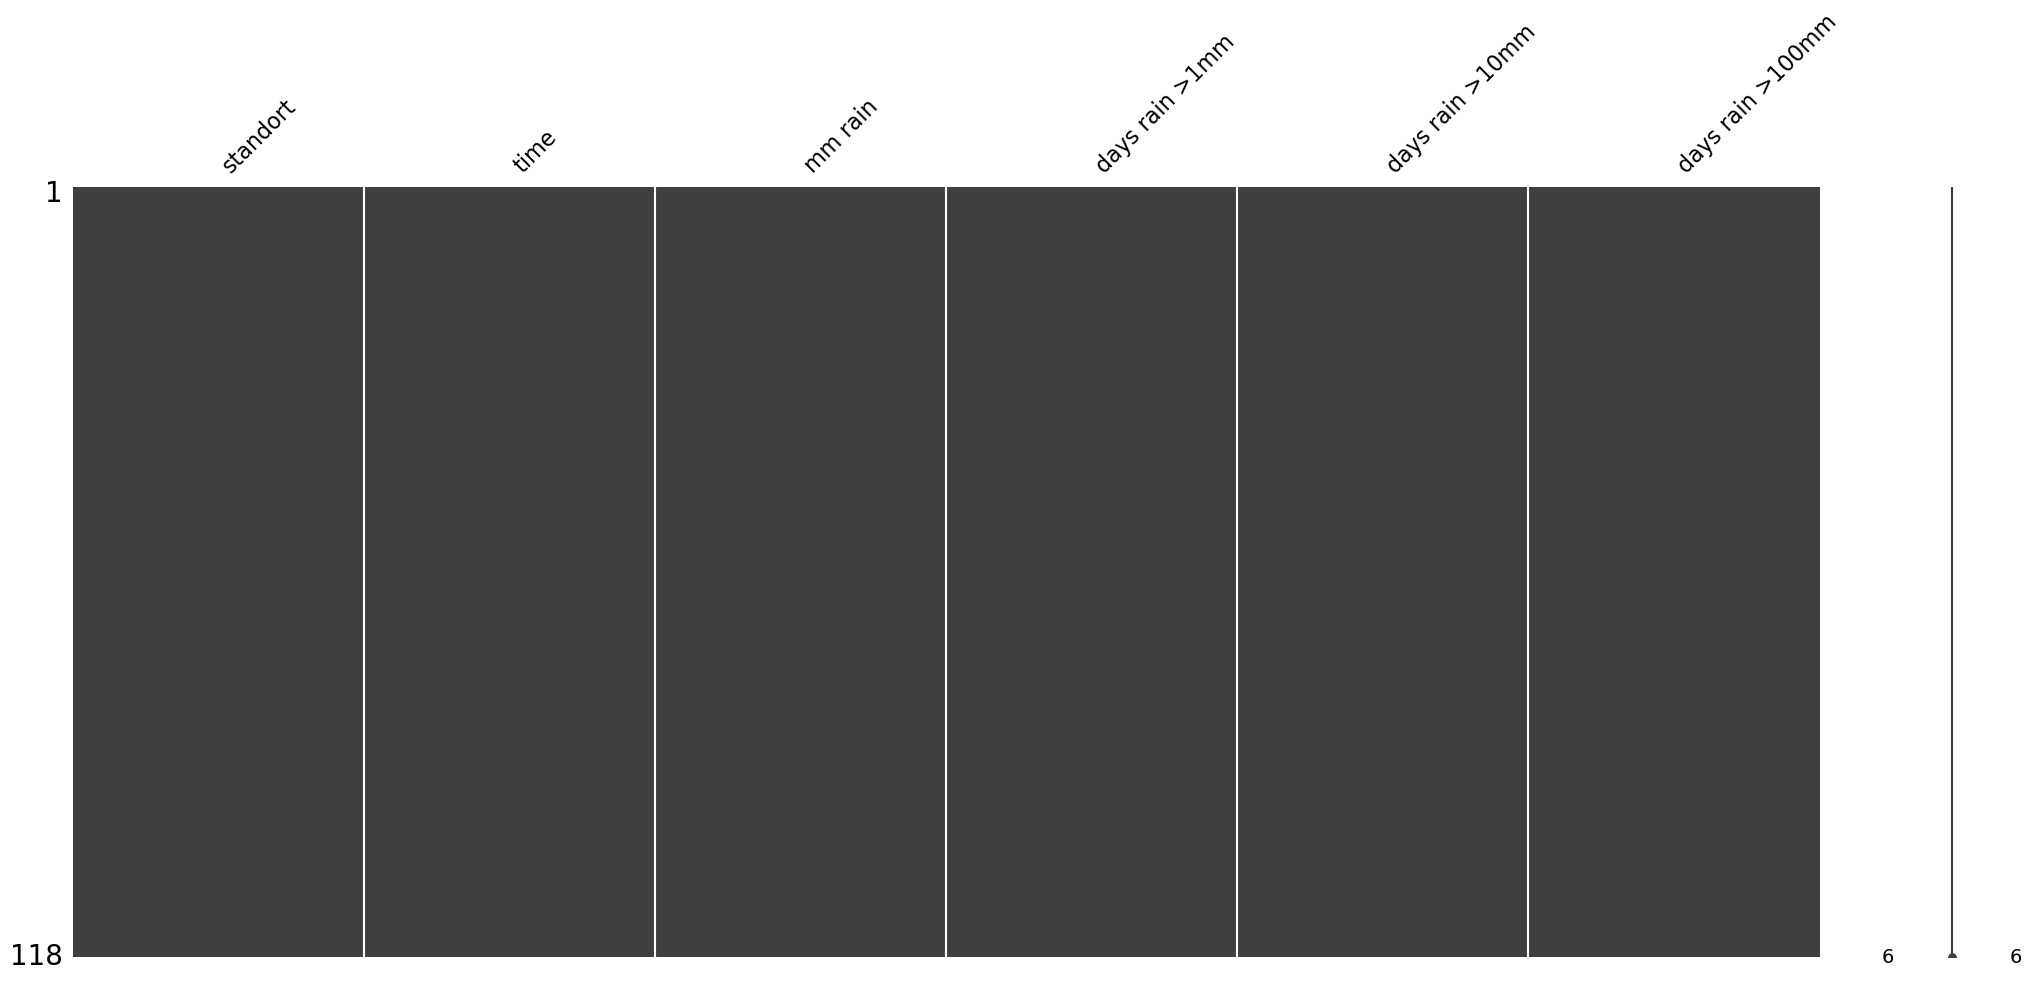

In [41]:
ph.show_na(weather_vdch)